# 카카오톡 감정 교류형 챗봇을 만들기 위한 Transformer 모델링 



#0. 필요한 Dependencies



이 프로젝트를 위해 필요한 라이브러리 및 도구를 설치한다.

In [ ]:
# 필요한 Dependencies 설치
import urllib.request

!pip install WordCloud # WordCloud 설치 
!pip install transformers # Transformers 설치
!pip install tensorflow # tensorflow 업데이트
!pip install plotly # plotly 업데이트
! pip install tensorflow-datasets # Tensorflow Datasets 설치
urllib.request.urlretrieve("http://macsplex.com/?module=file&act=procFileDownload&file_srl=2851&sid=ea4a36b12467c4446c21e70762c7d10f&module_srl=2822g", filename="AppleGothic.ttf") # 한글폰트설치

('AppleGothic.ttf', <http.client.HTTPMessage at 0x7f3ded1bb290>)

## 목차

### 1. 프로젝트 배경
> #### 1-1. 프로젝트의 계기
> #### 1-2. 데이터 선정 이유
> #### 1-3. 시험할 가설

### 2. EDA

> #### 2-1. 데이터 전처리
> #### 2-2. EDA
> #### 2-3. 인사이트 정리

### 3. 모델링

> #### 3-1. 파이프라인 구축하기
> #### 3-2. 모델링 및 교차검증
> #### 3-3. 모델 평가

### 4. 결론

> #### 4-1. 프로젝트 리뷰
> #### 4-2. 배운 것
> #### 4-3. 앞으로의 과제

### 부록: 참조

# 1. 프로젝트 배경
## 1-1. 프로젝트 계기



여기는 카카오 대회의실, 나는 카카오톡 서비스의 개선을 담당하는 팀에서 근무하는 데이터 사이언티스트다. 최근 회사에는 "새로운 수익성을 낼 수 있는 아이템을 고안하는 팀에게 10억원의 포상을 주겠다."라는 공고가 떴다. 요즘 각 팀에서는 새로운 서비스 고안을 위한 자발적인 "Braininstorming" 회의가 유행이다. 우리 팀도 이에 질세라 그동안 서로 많은 대화를 하면서 각자 고민을 해 보았다. 오늘은 모두 모여서 두 시간 동안 회의를 가지면서 그동안 서로 고민한 내용을 공유하고, 각자 회사를 위해 출시할만한 새로운 서비스 아이디어에 대해 이야기 해 보기로했다.

가장 먼저 데이터 사이언티스트인 나의 차례였다. 나는 최근 코로나를 맞이한 언택트 시대에서, 사람과 사람과의 소통이 많이 단절되었음을 이야기했다. 내가 자주보는 한 의료매체에 따르면[1], 코로나 이후 많은 여성들과 젊은 사람들이 외로움을 느낀다고 한다. 외출과 모임 자제로 많은 이들이 소통과 인간 관계의 단절을 경험하면서, 관계주의적인 우리나라의 전통적인 삶에서 벗어나니 많은 허전함을 느끼는 것이다. 나는 이 점을 지적하며, 이런 외로움을 해소할 챗봇 서비스를 제안했다. 챗봇을 통해 대화를 하고 싶어하는 사람들에게 인간처럼 대화를 해주고, 공감과 위로를 할 수 있는 서비스를 제공하자는 것이었다. 또 다른 매체에 따르면[2] 국내 챗봇 시장은 51%의 성장률을 기록할 것이라고 예고했다. 그렇게 크다고 느껴지지 않을 수 있지만, 카카오톡이라는 압도적인 점유율의 메신저 플랫폼을 보유하고 있는 카카오 입장에서는, 충분히 시장 점유율을 활용해 이 시장의 주도권을 압도적인 비율로 가져올 수 있다고 어필했다. 
현재 카카오톡 상담하기에서만 벗어나, 엔터테인먼트용으로 활용하자는 제안이었고, 이를 구현하기 위한 모델을 만들어 보자는 것이었다.

팀원들은 나의 제안의 설득되었고, 내게 그것을 구현하기 위한 Action Plan을 물었다. 나는 일단 먼저 모델을 노트북 환경에서 만들어본 후, 그것을 다음 회의 때 팀원들에게 보여줄 것을 악속했다. 나는 한 달 동안 내 업무 시간 이외에 시간을 내어 챗못을 위한 모델을 만들고, 이를 한 달 후에 있을 두 번째 미팅에서 시연하기로 했다. 

나는 마지막으로 팀장님께 도움을 요청했다. 나는 카카오톡 회원들을 대상으로 일상적인 대화에서 나올 법한 질문들에 답하는 설문조사를 진행할 수 있는지 물었다. 그렇게 해서, 추첨을 통해 기프트콘 같은 것을 나누어 주는 이벤트를 진행할 수 있도록 하여, 이를 바탕으로 필요한 대화 데이터를 축적하자는 것이었다. 팀장님은 수긍하셨고, 해당 이벤트가 짧은 시일내에 이루어질 수 있는지 건의해 보겠다고 했다.

다음 날 나의 요청은 빠르게 받아들여져, 카카오톡 마케팅팀에서 "일상적인 당신의 대화를 들려주세요"라는 이벤트를 이틀 후에 바로 진행한다고 하였다. 나는, 마케팅팀에게 설문조사를 진행할 때, 각 회원이 참여한 대화에 대한 전체적인 감정을 어떻게 느꼈는지에 대해서도 물어보도록 요청했다. 얼마 후, 이벤트를 통해 총 10000여 명의 카카오톡 유저에게 1만여개 이상의 대화 데이터를 얻을 수 있었다. 또한, 만들어진 데이터에서는 다행히도 특별한 비속어나 특정 그룹을 혐오하는 내용이 보이지 않았으며, 대부분 전처리가 필요없이 깔끔하게 구성되었다. 나는 이 데이터를 이용해 챗봇에 필요한 자연어처리(NLP) 모델을 만들어 보기로 했다.

## 1-2. 데이터 선정 이유



사실 이 데이터는 [Chatbot_data_for_Korean v1.0](https://github.com/songys/Chatbot_data)[3]라는 데이터로써, 다음카페 "사랑보다 아름다운 실연"[4]에서 자주 나오는 이야기들을 참조하여 제작되었다. 이 데이터를 활용하는 이유는 사람이 말할 법한 일상적인 질문들이 인위적이지 않은 상당히 자연스러운 어투로 구성되어 있으며, 답변은 다소 인위적이더라도 무례하거나 특정한 그룹의 사람들을 혐오하는 비속어를 사용하지 않기 때문이다. 이는 지난 "이루다 사태"[5]에서도 보았듯이, 예의없고 몰상식한 챗봇은 큰 사회적 비난을 야기할 수 있기 때문에 반드시 주의해야하는 부분이다. 따라서, 이루다가 학습했던 방식으로 무작위로 다량의 데이터를 검증없이 학습하기 보다, 이미 검증된 데이터를 바탕으로 그 내용만을 학습함으로써 보다 "예의바르고 상식적인" 챗봇을 구현할 수 있도록 하기 위한 전략이다. 챗봇이 인간과 공감하고 인간을 위로하려면, 이러한 도덕적인 면이 매우 중요하다고 판단되기 때문이다.

데이터는 인간이 일상적으로 물어볼만한 질문들로 구성된 "Q" 칼럼, 상식적으로 이에 대해 챗봇이 답할 만한 내용들인 "A", 그리고 해당 문답에서 느껴지는 감정을 0(일상), 1(이별,부정), 2(사랑,긍정) 등으로 분류한 "label" 칼럼으로 구성되어있다. 이전에 언급했다시피 "Q"는 일상적으로 사람들이 이야기 할만한 질문들이며, "A"는 조금 인위적이지만 공손하고 예의바른 말투로 질문에 대해 공감과 위로를 할 수 있는 답변으로 구성되어있다. 이렇게 답변이 구성되어 있으므로, 챗봇을 이용하는 사람들이 최대한 감정적인 위로를 받을 수 있을 것이다. "label" 칼럼은 이 프로젝트에서 타킷 데이터로 활용될 것이며, "0"은 일상적인 느낌의 대화로써 특별한 감정이 없다고 판단하고, "1"은 이별, 슬픔, 걱정 등의 다소 부정적인 감정, "2"는 사랑, 기쁨, 즐거움 등의 긍정적인 감정으로 분류된다.



## 1-3. 시험할 가설



자연어처리 분야에서 가장 많이 활용되는 Transformer라는 모델을 세상에 처음 소개한 Google의 논문[6]에 따르면, Transformer는 영어-불어 번역 테스크에서 28% 정도의 정확도를 기록하여, 이전에 많이 활용되었던 RNN 및 CNN 기반의 성능을 모두 뛰어넘었다고 한다. 매우 낮은 정확도로 생각할 수 있지만, 챗봇을 위한 모델은 인간의 수많은 답변에 대해 매우 다양한 답을 예측해야 하기 때문에 다중 분류(Multi-class Classification) 문제에 속하며, 이진 분류(Binary Classification)처럼 80~90% 정도의 챗봇이 나오기 쉽지 않다. 논문에 따르면 이러한 성능도 P100 GPU 8개를 사용해 3.5일 동한 훈련을 시켜 이러한 성능이 나왔다고 한다. 그렇다면, 그 정도로 학습을 할 수 없는 나의 경우에는 조금 더 낮은 성능이 필요할 것이다. 그렇다면, 논문에서 얻은 28%의 성능을 3.5일과 24시간으로 나눈다면 약 0.33%의 정확도를 1시간 정도에 얻을 수 있다는 계산이 나오며, 이를 2시간 정도 학습을 시킨다면, 0.66%의 정확도를 얻을 수 있다는 계산이 나온다. 과연 한국어 대화 데이터를 활용해 2시간 정도만을 학습시켰을 때, 이정도 정확도 밖에 낼 수 없는 것일까? 즉, “한국어 문답 데이터로 Transformer 모델을 학습 시켰을 때 0.66%의 정확도를 낼 수 있다.”라는 가설을 세우고 이를 실험한다. 

**가설: "한국어 문답 데이터로 Transformer 모델을 학습 시켰을 때 0.66%의 정확도를 낼 수 있다."**


# 2. EDA
## 2-1. 데이터 탐구



일단 모델링 이전에 데이터를 전체적으로 탐구해보자. 가장 먼저 데이터에서 드러난 전체적인 감정 분류를 보기 위해, 라벨의 각 범주가 어떤 비율로 분표되어 있는지 확인해 본다. 전체 데이터에서 어떠한 감정이 드러났는지를 파악할 필요가 있다. "일상", "부정", "긍정"을 의미하는 각 타깃 라벨의 값이 어느 정도의 비율로 데이터에서 드러났는지 확인해볼 필요가 있다. 

In [ ]:
# 데이터 탐구하기
import pandas as pd

df = pd.read_csv("Chatbot_data-master/ChatbotData .csv")
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


타깃 라벨이 있지만, 각 라벨이 무엇을 의미하는지 직관적이지 않다. 각 라벨의 의미를 보여줄 수 있는 칼럼을 추가하고 이를 시각화 해보자.

In [ ]:
# 데이터의 타깃 라벨 클래스 비율 확인하기

# "sentiment"라는 각 라벨의 값이 어떤 감정을 표현하는지에 대한 데이터 추가하기
df_sent = []
for i in df["label"]:
  if i == 0:
    df_sent.append("일상")
  elif i == 1:
    df_sent.append("이별/부정")
  elif i == 2:
    df_sent.append("사랑/긍정")

df["sentiment"] = df_sent 
df

,Q,A,label,sentiment
0,12시 땡!,하루가 또 가네요.,0,일상
1,1지망 학교 떨어졌어,위로해 드립니다.,0,일상
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,일상
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,일상
4,PPL 심하네,눈살이 찌푸려지죠.,0,일상
...,...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2,사랑/긍정
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2,사랑/긍정
11820,흑기사 해주는 짝남.,설렜겠어요.,2,사랑/긍정
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2,사랑/긍정


In [ ]:
# 추가한 라벨을 바탕으로 전체적으로 데이터에서 드러난 감정 시각화

import plotly.express as px

fig = px.pie(df, names='sentiment',
             title='대화 데이터에서 드러난 감정')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

위 파이차트를 보면 각 타깃 라벨 사이에 존재하는 클래스 비율의 차이가 크지 않다. 또한 일상적인 대화 즉, 아무 감정이 없는 대화는 약 45%이며 감정이 존재하는(이별/부정, 사랑/긍정) 대화는 약 55%로 감정이 드러난 대화와 감정이 드러나지 않은 대화의 비율이 서로 상당히 균등하다. 

일단 타깃 라벨에서 드러난 세 가지 감정들이 서로 균일하다는 것을 확인하였으므로, 추후에 머신러닝을 위해 클래스를 균등하게 Resampling하는 것은 따로 필요하지 않아 보인다. 그렇다면, 타깃 데이터를 제외한 실제 대화 데이터에서는 어떤 모습일까?


본격적으로 데이터를 탐구하는 EDA과정을 위해, 먼저 문장으로 되어 있는 텍스트 데이터를 단어로 토큰화할 필요가 있다.

먼저 필요한 전처리가 있는지 확인할 것이다. 가장 기본적으로 데이터에 결측치가 있는지 확인한다. 

In [ ]:
# 결측치 존재여부 확인
df.isnull().sum()

Q            0
A            0
label        0
sentiment    0
dtype: int64

결측치는 존재하지 않는 것으로 보여 다행이다. 다음으로 WordCloud를 활용해 본격적으로 EDA를 시작해보자.

## 2-2. WordCloud시각화

먼저 WordCloud를 통해 어떤 용어들이 주요 분포도를 차지하고 있는지 알아볼 것이다. 이 과정에 필요한 모든 라이브러리를 불러오도록 한다.

In [ ]:
# 필요한 모듈 불러오기
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from matplotlib import rc
import pandas as pd 

아래는 WordCloud를 그리기 위해 데이터를 토큰화하는 과정이다. 

In [ ]:
# 문장 데이터를 단어화하는 함수

# wordcloud에 이미 정의된 불용어 정의 활용
stopwords = set(STOPWORDS)

def process_words(Series, STOPWORDS):
  # Stopwords 및 특수문자 필터링을 위한 준비
  comment_words = ''
  tokenized_text = []
  for i in zip(Series):

    # 문장을 string으로 만들기
    i = str(i)

    # 문장을 쪼개기
    tokens = i.split()

    tokenized_text.append(tokens)
    comment_words += " ".join(tokens) + " "
  return tokenized_text, comment_words

# 질문과 대답의 토큰화한 단어들을 리턴
tokenized_text_Q, comment_words_Q = process_words(df["Q"], STOPWORDS)
tokenized_text_A, comment_words_A = process_words(df["A"], STOPWORDS)


이제 토큰화된 데이터를 통해 WordCloud를 그려보자

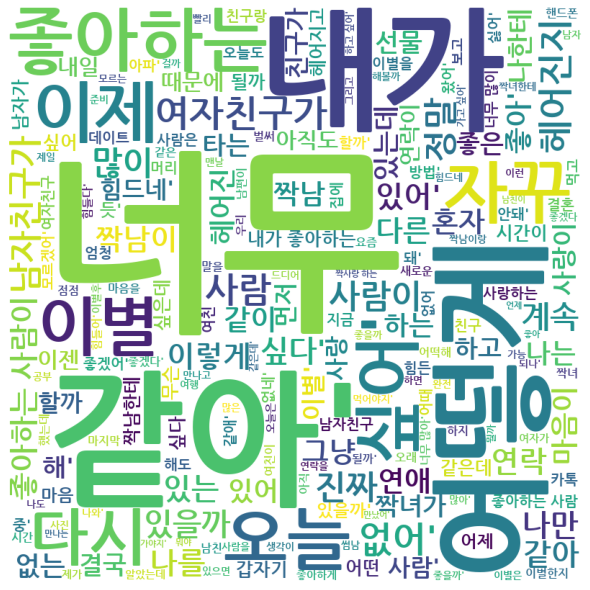

In [ ]:
# WordCloud 생성을 위한 함수 정의
def wordcloud(comment_words, stopwords):
  wordcloud = WordCloud(width = 800, height = 800, 
                font_path='AppleGothic.ttf',
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

  # WordCloud 그리기                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  
  plt.show() 

# 질문에 대한 WordCloud 보기
wordcloud(comment_words_Q, stopwords)

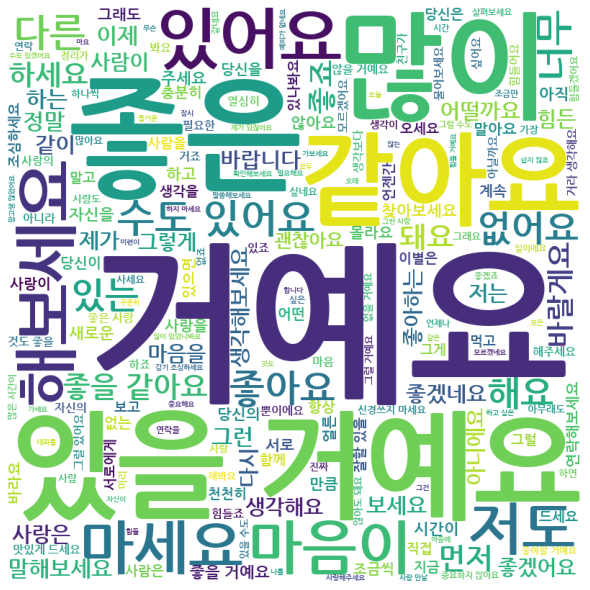

In [ ]:
# 대답에 대한 WordCloud 보기
wordcloud(comment_words_A, stopwords)

## 2-3. 인사이트 정리

인간의 질문과 챗봇이 할 대답의 용어 분포도를 비교해보자. 대체적으로 질문들은 좀 더 친근한 반말인 경우가 대부분이고, "너무"라는 용어가 가장 빈도가 큰 것으로 보아, 부사의 사용이 매우 잦은 것을 알 수 있다. 이러한 부사는 특정한 감정을 강조하기 위해 많이 쓰이므로, 특정한 감정을 아마도 강하게 느끼는 질문이 많았을 것으로 보인다. 반대로 대답은 "~요."로 끝내는 공손한 표현이 대부분이다. 인간의 그 어떤 질문에도 공손하고 예의바르게 상대를 높여서 부른다는 것을 알 수 있다. 인간을 달랠 수 있고, 인간의 감정에 공감할 수 있는 어투로 이루어져 있다는 것을 알 수 있다. 상대적으로 인간의 질문 만큼 "너무" 같은 부사가 많이 쓰여지지 않고, "거예요", "같아요", "있어요" 등 일상에서 무언가를 공손히 권유하거나 대답할 때 쓰이는 단어가 많이 등장하는 것을 알 수 있다. 하지만, 대답의 그러한 특성 때문인지, 상대적으로 대답에서는 질문보다 감정이 전체적으로 덜 드러난다는 느낌이 들기도 한다.

# 3. 모델링

## 3-1. 파이프라인 구축하기

대체로 자연어처리 분야에서는 BERT, XLNet, GPT 같은 Transformers 기반의 딥러닝 모델을 많이 활용하는 편이다. 이번 프로젝트에서도 Transformers를 활용한 딥러닝 모델링을 해보자. 먼저 딥러닝 모델 역시 머신 러닝 모델처럼 입맛에 맞게끔 데이터를 전처리 해 줄 필요가 있다.

먼저 정규표현식을 사용하여, 특수문자를 제거해준다. 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
import re

def remove_special_characters(data):
  processed_Q = []
  processed_A = []
  for i, j in zip(data["Q"], data["A"]):
      question = re.sub(r"([?.!,])", r" \1 ", i) 
      answer = re.sub(r"([?.!,])", r" \1 ", j)
      question = question.strip()
      answer = answer.strip()
      processed_Q.append(question)
      processed_A.append(answer)
  return processed_Q, processed_A

In [ ]:
questions, answers = remove_special_characters(df)

In [ ]:
len(questions), len(answers)

(11823, 11823)

다음으로, 용어들의 집합을 생성한다. Tensorflow 라이브러리를 활용한다. Transformer에서는 시퀀스의 시작을 알리는 토큰과 끝을 알리는 토큰이 필요하기 때문에 START_TOKEN 및 END_TOKEN을 각 문장에 더해 주어야 한다. 

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions+answers, target_vocab_size=2**15)

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [ ]:
def encoding(data):
  tokenized = []
  for i in data:
    j = START_TOKEN + tokenizer.encode(i) + END_TOKEN # START_TOKEN 및 END_TOKEN 추가
    tokenized.append(j)
  return tokenized

In [ ]:
tokenized_Q = encoding(questions)
tokenized_A = encoding(answers)

이후 MAX_LENGTH를 정하고 이보다 큰 데이터는 제거한다. 모델링에서 성능을 높이기 위함이다. Tensorflow Blog[7]에서는 이 값을 40으로 사용하였다.

In [ ]:
def filter_max_length(data, length):
  filtered = []
  for i in data:
    if len(i) <= length:
      filtered.append(i)
  return filtered

In [ ]:
MAX_LENGTH = 40
filtered_Q = filter_max_length(tokenized_Q, MAX_LENGTH)
filtered_A = filter_max_length(tokenized_A, MAX_LENGTH)

In [ ]:
len(filtered_Q), len(filtered_A)

(11823, 11823)

이후 딥러닝 모델의 성능을 올리기 위한 패딩을 진행한다.

In [ ]:
padding_Q = tf.keras.preprocessing.sequence.pad_sequences(filtered_Q, maxlen=MAX_LENGTH, padding = "post")
padding_A = tf.keras.preprocessing.sequence.pad_sequences(filtered_A, maxlen=MAX_LENGTH, padding = "post")

In [ ]:
padding_Q.shape, padding_A.shape

((11823, 40), (11823, 40))

## 3-2. 모델링 및 교차검증

### 1) Scaled Dot Product Attention

본격적으로 모델링을 위한 작업을 시작해보자. Transformer는 여느 다른 seq2seq 모델처럼 Encoder와 Decoder로 이루어져있다. 그러나, RNN과 CNN과는 다르게, Multi-head attention 레이어로 구성되어있고, 각각은 다수의 Scaled Dot Product Attention이라는 기법을 사용한다.
이는 아래와 같은 공식을 이용해 계산된다.


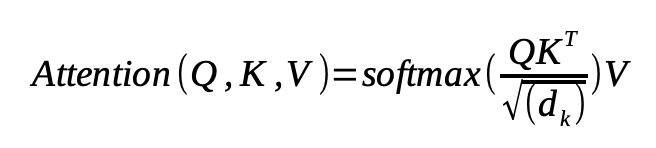

각 부분이 의미하는 것은 아래와 같다.

* Q: Query
* K: Key
* V: Value

Key에 softmax 활성화 함수가 적용되기 때문에, Key값에 따라 Query가 얼마나 중요한지를 결정한다. 활성화함수의 출력 값과 Value의 곱이 Attention 가중치라고 할 수 있다. 이를 통해 어떠한 단어에 주의하여 모델이 학습을 해야하는지를 알게된다.

In [ ]:
# Scaled Dot Product Attention 
 
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # matmul_qk scale하기
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩 토큰을 0로 만들기 위해 mask 추가
  if mask is not None:
    logits += (mask * -1e9)

  # 마지막 축에서 softmax를 표준화한다 (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

### 2) Multi-head Attention Layer

시퀀스형 모델은 레이어를 서로 쌓는 Stack 형태를 통해 빠르게 모델을 만들 수 있게 해준다는 강점이있다. 하지만, 더 복잡한 비시퀀스(non-sequential)형 모델은 함수형 API와 모델 서브클래싱(subclassing)이 필요하다. “tf.keras” API는 서로 다른 API의 스타일을 엮고 매칭할 수 있게 해준다. 모델 서브클래싱의 가장 중요한 기능은 디버깅이다. “call()” 메소드를 통해 breakpoint를 설정하여, nuumpy array 처럼 각 레이어의 입력 및 출력값을 관찰할 수 있다. 이는 디버깅을 매우 쉽게할 수 있게 해준다.
바로 이 모델 서브클래싱을 활용하여 MultiHeadAttention 레이어를 적용할 수 있다. Multi-head attention은 아래와 같은 4가지 과정으로 진행된다.
선형 레이어(linear layer)를 Head로 나누기
Scaled dot-product attention
Head의 연결(concatenation)
최종 선형 레이어 도출
각 multi-head attention block은 query, key, value로 이루어진 dictionary를 입력값으로한다. 함수형 API를 활용하는 모델 서브클래싱을 활용하면, 입력값은 단수 인자(single argument)로 유지되기 때문에, query, key 및 value를 반드시 dictionary로 묶어야한다.
이후 입력값은 dense 레이어를 지나며 여러개의 head로 나누어진다. 위에 정의된 “scaled_dot_product_attention()”는 각 head에 적용된다. 이는 모델의 효율성을 위한 과정으로 알려져있다. 이 Attention 과정을 위해 알맞은 masking이 반드시 활용되어야한다.
각 head에 대한 Attention 출력은 서로 연결(concatenation)되고, 마지막 dense 레이어를 지나게된다.
하나의 attention head 대신 query, key 및 value 등은 여러 개의 head로 나뉘어진다. 이러한 과정은 모델이 서로 다른 위치나 공간에 표현된 정보에 주의를 기울여 학습할 수 있게 한다. 나뉘어진 각 head는 축소된 차원을 가지게 되며, 하나의 head attention으로 모든 차원을 고려했을 때 연산되는 량과 큰 차이가 없다.

In [ ]:
# Multi-head Attention
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 선형 레이어(linear layers)
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # Head를 나누기
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # Head 연결(concatenation)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 선형 레이어 
    outputs = self.dense(concat_attention)

    return outputs

### 3) Positional Encoding

Positional Encoding(위치 인코딩)은 Transformer에서 모델이 각 문장의 시퀀스를 파악할 수 있는 중심 기법이다. 각 문장이 입력될 때마다, 각 문장의 위치에 대한 encoding값을 더함으로써 모델이 문맥을 학습할 수 있다. 홀수 인덱스에는 cosine, 짝수 인덱스에는 sine함수를 사용한다. 이 함수를 사용하는 이유는, 그 어떤 offset값인 "k"에 대해서도, PE_(pos+k)가 PE_pos의 선형함수로 표현될 수 있기 때문이며, 그러므로 모델이 상대적인 위치에 주의하여 학습을 할 수 있게 해 줄 수 있다고 가정했기 때문이다. 

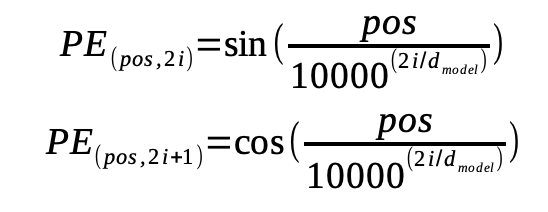

In [ ]:
# Positional Encoding
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 아이템들에 sine 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 아이템들에 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 4). Encoder 형성

다음으로 Encoder를 구성해준다. 이 인코더는 6개의 같은 성질을 가진 레이어로 이루어져 있으며, 각 레이어는 Multi-head attention (padding mask 활용)레이어와 
두 Dense 레이어 (dropout 활용) 등, 두 가지의 서브 레이어를 갖게 된다. 첫 레이어는 multi-head self-attention 기법이라하며, 두 번째 레이어는 단순한 위치 기반으로 완전히 연결된(fully-connected) feed-forward network라 할 수 있다. 두 서브 레이어 각각에는 residual connection이 있고, 레이어 표준화(layer normalization)이 적용된다. 각 레이어의 출력값은 LayerNorm(x + Sublayer(x))가 되고, Sublayer(x)는 서브 레이어 자체에 구현된 함수를 말한다.


In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

아래의 3가지 부분들로 이루어진 Encoder를 형성한다.

* 입력 Embedding 값
* Positional encoding
* “N”개의 Encoder 레이어들

입력값은 positional encoding값이 합산된 embedding을 통과한다. 이 합산의 출력은 encoder 레이어에 입력된다. Encoder의 출력은 Decoder의 입력값으로 활용된다.

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 5) Decoder 형성

각 Decoder 레이어는 아래의 서브레이어로 구성된다.

* Masking된 multi-head attention (look ahead masking 및 padding masking활용)
* Multi-head attention (padding masking활용). Value 및 Key는 Encoder출력값을 입력값으로 받는다. Query는 Masking된 Multi-head attention 서브레이어의 출력값을 받는다.
* Dropout을 활용한 2개의 dense 레이어

Query가 Decoder의 첫 attention block 출력값을 받고, Key가 Encoder의 출력값을 받기 때문에, Attention 가중치(weight)는 Encoder의 출력 대비 Decoder의 입력값의 중요성을 나타낸다고 할 수 있다. 즉, Decoder는 Encoder 출력값을 기반으로 다음 단어를 예측할 수 있으며, 스스로 출력하는 값에 대해 주의(self-attention)을 기울일 수 있다.

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

아래 3 부분으로 이루어진 Decoder를 형성한다.

* Output Embedding
* Positional Encoding
* “N”개의 Decoder 레이어

타깃값은 positional encoding값을 합산한 embedding을 통과한다. 이 합산의 출력은 Decoder 레이어의 입력값으로 활용된다. Decoder의 출력은 최종 선형 레이어의 입력값으로 활용된다.

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 6) Transformer 모델 형성



Transformer는 Encoder, Decoder 및 최종 선형 레이어로 이루어져있다. Decoder의 출력값은 최종 선형 레이어의 입력값으로 활용되고, 그 출력값은 리턴된다.
“enc_padding_mask” 및 “dec_padding_mask”는 모든 padding 토큰을 masking out하기 위해 사용되었다. “look_ahead_mask”는 문장에 있는 다음 토큰을 masking out하는데 활용된다. Masking의 크기가 입력 시퀀스 크기에 따라 변화하기 때문에, lambda 레이어를 활용해 이러한 mask를 생성한다.
일단 Transformer를 구동하기 위해 padding mask를 형성하고, look ahead mask를 만드는 함수를 선언해 주어야한다.


In [ ]:
# padding mask 생성
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (배치 크기, 1, 1, 시퀀스 크기)
  return mask[:, tf.newaxis, tf.newaxis, :]
 
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

이제 Transformers 딥러님 모델을 만들어본다.

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # 첫 Attention block에서 Decoder의 입력값을 위해 미래 토큰을 masking한다. 
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # 두 번째 Attention block에서 Encoder의 출력을 masking한다. 
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

비용함수를 만들어, 각 EPOCH마다 손실을 계산한다.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

다음으로 딥러닝의 학습률(learning_rate) 조절할 수 있는 scheduler를 형성한다.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 7) 교차 검증(Cross Validation)

Cross Validation을 실시하여 가장 높은 정확도를 기록할 수 있는 하이퍼파라미터 값을 찾는다. 데이터는 BATCH_SIZE를 32, 64, 128의 세가지 경우를 시험하고, 하이퍼파라미터는 DROPOUT을 0.1, 0.2, 0.3의 세가지 값을 시험한다. 나머지 파라미터는 논문에 나와있는 파라미터이며, 고정되지 않으면 학습이 되지 않기 때문에, 이 두가지 파라미터에 대해서만 교차검증을 수행한다. 또한, 너무 많은 시간이 걸리는 것을 막기위해 EPOCH는 20번으로 제한했다. 이 정도의 EPOCHS값이면 각 케이스당 약 2시간 정도의 학습으로 충분할 것이다.

먼저 데이터를 배치단위로 나누어 활용할 수 있도록 준비한다. 주의할 것은, 실제 모델링을 위해서는 이전에 패딩을 위해 생성한 첫 토큰과 마지막 토큰을 제거해 주어야한다는 것이다.

In [ ]:
# Transformer의 입맛에 맞는 형태의 데이터 준비하기
datasets = []
BATCH_SIZE = [32, 64, 128] # 3가지 값 교차검증
BUFFER_SIZE = 20000
for i in BATCH_SIZE:
  # Decoder는 이전 출력값을 입력으로 사용한다
  # START_TOKEN을 출력에서 제거해준다.
  dataset = tf.data.Dataset.from_tensor_slices((
      {
          'inputs': padding_Q,
          'dec_inputs': padding_A[:, :-1]
      },
      {
          'outputs': padding_A[:, 1:]
      },
  ))

  dataset = dataset.cache()
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(i)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  datasets.append(dataset)

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2 
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = [0.1, 0.2, 0.3] # 3가지 값 교차검증
VOCAB_SIZE = tokenizer.vocab_size + 2 # START_TOKEN 및 END_TOKEN 고려
results = []

for k in DROPOUT:
  for i,j in zip(BATCH_SIZE, datasets):
      print("-"*50)
      print("batch size:{} dropout:{}".format(i,k))
      tf.keras.backend.clear_session()

      model = transformer(
          vocab_size=VOCAB_SIZE,
          num_layers=NUM_LAYERS,
          units=UNITS,
          d_model=D_MODEL,
          num_heads=NUM_HEADS,
          dropout=k)

      # 딥러닝 모델의 학습 보조 장치 준비
      learning_rate = CustomSchedule(D_MODEL)

      optimizer = tf.keras.optimizers.Adam(
      learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

      def accuracy(y_true, y_pred):
        # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
        y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
        return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

      model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

      EPOCHS = 20
      result = model.fit(j, epochs=EPOCHS)
      training_info = {"batch size": i, "dropout": k, "results": result}
      results.append(training_info)

--------------------------------------------------
batch size:32 dropout:0.1
Epoch 1/20
370/370 [==============================] - 68s 162ms/step - loss: 1.3725 - accuracy: 0.0194
Epoch 2/20
370/370 [==============================] - 60s 162ms/step - loss: 0.8606 - accuracy: 0.0498
Epoch 3/20
370/370 [==============================] - 60s 162ms/step - loss: 0.7539 - accuracy: 0.0530
Epoch 4/20
370/370 [==============================] - 60s 162ms/step - loss: 0.6806 - accuracy: 0.0567
Epoch 5/20
370/370 [==============================] - 60s 163ms/step - loss: 0.6001 - accuracy: 0.0629
Epoch 6/20
370/370 [==============================] - 60s 163ms/step - loss: 0.5151 - accuracy: 0.0723
Epoch 7/20
370/370 [==============================] - 60s 163ms/step - loss: 0.4345 - accuracy: 0.0831
Epoch 8/20
370/370 [==============================] - 61s 164ms/step - loss: 0.3528 - accuracy: 0.0922
Epoch 9/20
370/370 [==============================] - 60s 163ms/step - loss: 0.2758 - accuracy: 0.1

교차 검증을 통해 얻은 데이터에서 가장 낮은 바용함수값을 기록한 값을 찾는다.

In [ ]:
# 교차 검증 결과에서 비용함수만 보기
losses = []
loss_records = {}
for i in results:
  records = i["results"].history
  min_loss = records["loss"][len(records["loss"])-1]
  print(min_loss)
  losses.append(min_loss)

0.04058300331234932
0.02650698460638523
0.209491565823555
0.11144159734249115
0.07171210646629333
0.3339558243751526
0.24698926508426666
0.18445985019207
0.41477182507514954


In [ ]:
loss_records["loss"] = losses
loss_records

{'loss': [0.04058300331234932,
  0.02650698460638523,
  0.209491565823555,
  0.11144159734249115,
  0.07171210646629333,
  0.3339558243751526,
  0.24698926508426666,
  0.18445985019207,
  0.41477182507514954]}

확인한 비용함수를 바탕으로 최적화시킨 하이퍼 파라미터들과 비교할 수 있게 데이터프레임을 구성한다.

In [ ]:
# 최적화된 값을 비교하기 위한 데이터프레임 구성
final_data = pd.DataFrame(results, loss_records["loss"])
final_data = final_data.drop(columns=["results"])
final_data = final_data.reset_index()
final_data = final_data.rename(columns = {"index": "loss"})
final_data

,loss,batch size,dropout
0,0.040583,32,0.1
1,0.026507,64,0.1
2,0.209492,128,0.1
3,0.111442,32,0.2
4,0.071712,64,0.2
5,0.333956,128,0.2
6,0.246989,32,0.3
7,0.184460,64,0.3
8,0.414772,128,0.3


In [ ]:
# 최소비용함수값을 갖는 하이퍼 파라미터값 검색
final_data[final_data["loss"] == min(final_data["loss"])]

,loss,batch size,dropout
1,0.026507,64,0.1


### 8) 최종모델학습(Final Training)

위 데이터 프레임에서 최소비용함수값을 갖는 최적화된 하이퍼파라미터값을 찾아 최종모델을 학습시킨다.

In [ ]:
# 최적화된 BATCH_SIZE를 활용해 데이터를 다시 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# Decoder는 이전 출력값을 입력으로 사용한다
# START_TOKEN을 출력에서 제거해준다.
dataset = tf.data.Dataset.from_tensor_slices((
      {
          'inputs': padding_Q,
          'dec_inputs': padding_A[:, :-1]
      },
      {
          'outputs': padding_A[:, 1:]
      },
  ))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 최종 하이퍼파라미터 값
NUM_LAYERS = 2 
D_MODEL = 256 
NUM_HEADS = 8
UNITS = 512 
DROPOUT = 0.1 
VOCAB_SIZE = tokenizer.vocab_size + 2 # START_TOKEN 및 END_TOKEN 고려

# 이전 학습 결과 제거
tf.keras.backend.clear_session()

# 모델링
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
# 딥러닝 모델의 학습 보조 장치 준비
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
# 최종 학습
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
185/185 [==============================] - 38s 180ms/step - loss: 1.4242 - accuracy: 0.0157
Epoch 2/20
185/185 [==============================] - 33s 180ms/step - loss: 1.1595 - accuracy: 0.0494
Epoch 3/20
185/185 [==============================] - 33s 180ms/step - loss: 0.8782 - accuracy: 0.0499
Epoch 4/20
185/185 [==============================] - 33s 179ms/step - loss: 0.7813 - accuracy: 0.0507
Epoch 5/20
185/185 [==============================] - 33s 180ms/step - loss: 0.7212 - accuracy: 0.0541
Epoch 6/20
185/185 [==============================] - 33s 179ms/step - loss: 0.6751 - accuracy: 0.0565
Epoch 7/20
185/185 [==============================] - 33s 181ms/step - loss: 0.6247 - accuracy: 0.0603
Epoch 8/20
185/185 [==============================] - 33s 179ms/step - loss: 0.5625 - accuracy: 0.0657
Epoch 9/20
185/185 [==============================] - 33s 180ms/step - loss: 0.4990 - accuracy: 0.0739
Epoch 10/20
185/185 [==============================] - 33s 180ms/step - l

## 3-3. 모델 평가

검증을 위해, 한번에 하나씩 추론(inference)을 하며, 이전 시점의 출력값을 입력값으로 활용한다. 주의할 것은, 보통 추론을 위해 dropout을 적용하지는 않지만, 모델의 “training” 인자를 지정하지 않았다. “mask” 및 “training”이 이미 만들어져 있기 때문에, “model”을 검증할 때 “model(inputs, training=False)를 지정해주면 모델이 추론 모드로 들어갈 수 있다.

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=True)
    

    # 시퀀스 크기만한 차원에서 가장 마지막 단어를 선택한다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 예측된 토큰의 ID가 마지막 토큰과 같으면 결과를 리턴한다. 
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # Decoder에 입력값으로 주어진 예측된 ID값을 출력값에 연결한다. 
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

질문 데이터를 입력하여, 그에 맞는 답변이 나오는지 확인한다. 

In [ ]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
output = predict("영화 볼래?")

Input: 영화 볼래?
Output: 최신 영화가 좋을 것 같아요 .


In [ ]:
output = predict("고민 있어")

Input: 고민 있어
Output: 네 말씀하세요 .


In [ ]:
output = predict("너무 좋아!")

Input: 너무 좋아!
Output: 성공을 기원합니다 .


In [ ]:
output = predict("카페갈까?")

Input: 카페갈까?
Output: 세상에는 예상하지 못한 일들이 자주 일어나는 것 같아요 .


In [ ]:
output = predict("1지망 학교 떨어졌어")

Input: 1지망 학교 떨어졌어
Output: 위로해 드립니다 .


In [ ]:
output = predict("12시 땡!")

Input: 12시 땡!
Output: 하루가 또 가네요 .


입력 텍스트 데이터에 대한 답변을 하나씩 검증해보자. "영화 볼래?"라는 물음에 대해서는 알맞은 답을 했다. "고민 있어"라는 말에는 "네 말씀하세요"라며 들어보려는 태도를 취했다. 그러나 "너무 좋아!"라는 말에 대해서는 "성공을 기원합니다"라는 그럴듯 하지만 다소 애매한 반응을 보였다. "카페갈까?"라는 말에는 정말 관련이 없는 이상한 답변을 내놓았다. 그러나 "1지망 학교에 떨어졌어"라는 말에는 "위로해 드립니다"라는 정확한 답을 내놓았고, 마찬가지로 "12시 땡!"이라는 말에는 "하루가 또 가네요."라며 다시 한번 정확한 답을 내놓았다. 

결국, 챗봇의 정확도를 전체적으로 보면 15%가 약간 안되는 수준이지만, 이 문제가 다중클래스-다중출력(Multi-class Multi-output)임을 생각한다면, Chance Level은 100/(데이터의 크기)이므로, 100/11823 = 0.08%이다.

결국 이 챗봇 모델의 Chance Level은 0.01%가 안되는 수준임을 감안할 때, 14%는 이에 1400배나 되는 확률이다. 이 챗봇은 문제의 특성을 고려할 때 그렇게 나쁜 수준의 모델이 아니며, 오히려 상당히 괜찮은 성능을 가졌다고 볼 수 있다. 

# 4. 결론



## 4-1. 프로젝트 리뷰

결국 결론은 챗봇은 기존에 목표했던 0.66%의 성능을 훨씬 상회하는 14%의 성능을 보임으로써, 논문에서 3.5일 동안 8개의 GPU로 학습시켰던 모델만큼은 아니지만, 분류해야할 범주가 매우많은 문제의 특성을 고려할 때 학습 시간대비 상당히 만족스러운 결과를 얻을 수 있다고 수 있다. 만약 챗봇이 단순한 고객지원용 챗봇이었다면 훨씬 더 범위가 줄어들 수 있고 정확도가 더 높아질 수 있지만, 사람의 다양하고 복잡한 감정과 상황에 반응해야하는 감정교류형 챗봇은 그만큼의 정확도를 내기 어려운 것이 사실이다. 하지만 14%의 정확도는 약 10000여개가 넘는 범주에서 모델이 무려 1300에서 1400개의 답변은 맞게 예측을 할 수 있다는 것을 고려한다면, 그렇가 낮은 성능이라고도 할 수 없다. 어쨌든 우리가 예상해 세운 가설보다도 훨씬 높은 정확도를 훨씬 더 짧은 시간에 1개의 GPU만으로 얻는 것이 가능했다.



## 4-2. 배운 것

이 프로젝트를 진행하면서, Transformer가 발표되었던 논문인 "Attention is all you need"를 읽으면서, 자연어처리의 최첨단 모델의 세부적인 원리와 구조에 대해 배울 수 있었다. 이전에 존재했던 RNN및 CNN 기반의 모델보다도 더 구조적으로 단순하면서도 Attention이라는 개념을 활용하여 문장의 문맥을 더욱 효과적으로 학습할 수 있는 모델로써, 문장에서 각 단어들의 가중치를 활용해 각 단어의 위치에 따른 중요성을 학습함으로써 문맥을 파악하는 기술이다. 이 모델을 바탕으로 자연어 이해에 특화된 BERT라는 모델과 자연어 생성에 특화된 GPT라는 모델이 나왔다. Transformer를 이해함으로써 앞으로도 BERT와 GPT계열의 좀 더 발전된 형태의 자연어처리 모델들도 논문을 읽으며 학습해 볼 수 있을 것이라는 생각이들었다.

## 4-3. 앞으로의 과제

물론, 많은 것들이 좋았지만, 조금 아쉬운 것도 있었다. 일단 프로젝트를 진행하면서 내가 스스로 Transformer의 코드를 모두 구현하지는 못했고, 데이터 파이프라인 구성과 교차검증을 제외한 거의 모든 부분은 Tensorflow블로그 자료[7]를 통해 가져왔다. 그래서 사실상 이 모든 코드에서 순수하게 내 손으로 했던 것은 많이 봐야 40% 정도라고 할 수 있다. 또한 BATCH_SIZE를 이용해 데이터를 나누는 것이 아닌, tensorflow의 dataset을 build하고나서 KFold Split 을 통해 교차검증을 하는 방법을 찾아내지 못한 것이 아쉽기도하다. 마지막으로 하이퍼파라미터를 교차검증할 때에도 논문에서 본 것과 같이 대부분의 하이퍼파라미터는 모델 구성상 건드릴 수 없었고, 시간이 너무 많이 걸릴 것을 우려하여 여기서 다룬 dropout rate정도만을 활용했다. 비록 내가 할 수 있는 부분은 최대한 해본 것이지만, 다음에는 기회가 된다면 Transformer의 원리를 이해하는 것을 넘어서서, 이를 코드로 내손으로 처음부터 끝까지 구현해 볼 수 있는 수준으로 끌어올리고 싶다는 생각을 했다. 내가 좀 더 Transformer를 내 입맞에 맞게 다양한 방법으로 파라미터를 수정해가며 다루어 볼 수 있는 수준이 된다면, 그 어떤 논문을 읽어도 두렵지 않을 것 같다. 물론, 앞으로도 더 많은 논문을 읽어보고 학습을 하면서 실력을 키우는 것만이 그렇게 될 수 있는 길이라 믿는다. 그렇게만 할 수 있다면, 내가 만든 챗봇 모델의 성능을 더 올릴 수 있는 방법을 찾기가 더 용이해지지 않을까? 논문에 나온 것보다 훨씬 더, 시간적으로나 물리적인 면에서 경제적인 방법으로 Transformer 챗봇 모델의 성능을 끌어올릴 수 있는 방법을 찾는 것이 앞으로의 숙제라고 할 수 있다. 이를 위해서는 앞으로도 계속 Transformer 모델을 더 잘 이해하고 내손으로 프로그램할 수 있도록 공부해야 할것이다. 

### 부록: 참조
[1] [여성·젊은층에 더 짙게 드리우는 ‘코로나 블루’의 그늘
](http://www.doctorstimes.com/news/articleView.html?idxno=213187)

[2] [챗봇, 국내 시장 성장률 51%에 달해…“코로나로 변화된 업무 환경 협업도구로 사용 중”
](http://www.newsian.co.kr/news/articleView.html?idxno=44459)

[3] [Chatbot_data_for_Korean v1.0](https://github.com/songys/Chatbot_data)

[4] [사랑보다 아름다운 실연](http://cafe116.daum.net/_c21_/home?grpid=1bld)

[5] [AI ‘이루다’ 멈췄지만…성차별·혐오는 인간에게 돌아온다
](http://www.hani.co.kr/arti/society/women/978313.html)

[6] [Attention Is All You Need
](https://arxiv.org/abs/1706.03762)

[7] [A Transformer Chatbot Tutorial with TensorFlow 2.0](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html)

